# Import Libraries and Dataset

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.model_selection import GridSearchCV

import pickle

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('flights.csv')
df

,index,Airline,Date_of_Journey,Source,Destination,Dep_Time,Duration,Total_Stops,Additional_Info,Price
0,0,Jet Airways,2019-01-03,Banglore,New Delhi,11:40,13h 5m,1 stop,No info,26890
1,1,SpiceJet,2019-01-03,Banglore,New Delhi,15:35,8h 5m,1 stop,1 Long layover,7744
2,2,Jet Airways,2019-01-03,Banglore,New Delhi,8:00,12h 20m,1 stop,No info,27992
3,3,Air India,2019-01-03,Banglore,New Delhi,8:50,39h 5m,2 stops,No info,17135
4,4,Jet Airways,2019-01-03,Banglore,New Delhi,11:40,23h 45m,1 stop,No info,25735
...,...,...,...,...,...,...,...,...,...,...
10678,10678,Multiple carriers,2019-12-06,Delhi,Cochin,9:15,9h 45m,1 stop,No info,11622
10679,10679,IndiGo,2019-12-06,Kolkata,Banglore,8:10,4h 50m,1 stop,No info,5069
10680,10680,Jet Airways,2019-12-06,Delhi,Cochin,22:50,20h 10m,1 stop,No info,14714
10681,10681,Air Asia,2019-12-06,Kolkata,Banglore,7:35,15h 55m,1 stop,No info,5192


# Dataset Transform

In [6]:
df = df[['Airline', 'Date_of_Journey', 'Duration', 'Additional_Info', 'Price']]
df.head()

,Airline,Date_of_Journey,Duration,Additional_Info,Price
0,Jet Airways,2019-01-03,13h 5m,No info,26890
1,SpiceJet,2019-01-03,8h 5m,1 Long layover,7744
2,Jet Airways,2019-01-03,12h 20m,No info,27992
3,Air India,2019-01-03,39h 5m,No info,17135
4,Jet Airways,2019-01-03,23h 45m,No info,25735


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Duration         10683 non-null  object
 3   Additional_Info  10683 non-null  object
 4   Price            10683 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 417.4+ KB


## Airline Column

In [9]:
df.groupby(['Airline']).agg({'Price': 'mean'}).sort_values('Price', ascending=False)

,Price
Airline,
Jet Airways Business,58358.666667
Jet Airways,11643.923357
Multiple carriers Premium economy,11418.846154
Multiple carriers,10902.678094
Air India,9611.210616
Vistara Premium economy,8962.333333
Vistara,7796.348643
GoAir,5861.056701
IndiGo,5673.682903


In [10]:
df['Airline'] = df['Airline'].map({'GoAir': 'LCC', 'IndiGo': 'LCC', 'Air Asia': 'LCC', 'SpiceJet': 'LCC', 'Trujet': 'LCC',
                                   'Vistara': 'Full service', 'Air India': 'Full service', 'Jet Airways': 'Full service',
                                   'Vistara Premium economy': 'Full service premium economy', 'Jet Airways Business': 'Full service business',
                                   'Multiple carriers': 'Multiple carriers', 'Multiple carriers Premium economy': 'Multiple carriers premium economy'
                                  })

In [11]:
df.head()

,Airline,Date_of_Journey,Duration,Additional_Info,Price
0,Full service,2019-01-03,13h 5m,No info,26890
1,LCC,2019-01-03,8h 5m,1 Long layover,7744
2,Full service,2019-01-03,12h 20m,No info,27992
3,Full service,2019-01-03,39h 5m,No info,17135
4,Full service,2019-01-03,23h 45m,No info,25735


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Duration         10683 non-null  object
 3   Additional_Info  10683 non-null  object
 4   Price            10683 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 417.4+ KB


## Date of Journey Column

In [14]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10683 non-null  object        
 1   Date_of_Journey  10683 non-null  datetime64[ns]
 2   Duration         10683 non-null  object        
 3   Additional_Info  10683 non-null  object        
 4   Price            10683 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 417.4+ KB


In [16]:
date_of_journey_index = df.columns.get_loc('Date_of_Journey')

df.insert(date_of_journey_index + 1, 'Day', df['Date_of_Journey'].dt.day)
df.insert(date_of_journey_index + 2, 'Month', df['Date_of_Journey'].dt.month)
df.insert(date_of_journey_index + 3, 'Year', df['Date_of_Journey'].dt.year)

df.head()

,Airline,Date_of_Journey,Day,Month,Year,Duration,Additional_Info,Price
0,Full service,2019-01-03,3,1,2019,13h 5m,No info,26890
1,LCC,2019-01-03,3,1,2019,8h 5m,1 Long layover,7744
2,Full service,2019-01-03,3,1,2019,12h 20m,No info,27992
3,Full service,2019-01-03,3,1,2019,39h 5m,No info,17135
4,Full service,2019-01-03,3,1,2019,23h 45m,No info,25735


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10683 non-null  object        
 1   Date_of_Journey  10683 non-null  datetime64[ns]
 2   Day              10683 non-null  int32         
 3   Month            10683 non-null  int32         
 4   Year             10683 non-null  int32         
 5   Duration         10683 non-null  object        
 6   Additional_Info  10683 non-null  object        
 7   Price            10683 non-null  int64         
dtypes: datetime64[ns](1), int32(3), int64(1), object(3)
memory usage: 542.6+ KB


## Duration Column

In [19]:
df['Hours'] = df['Duration'].str.split(' ').str[0].str.split('h').str[0]
df['Minutes'] = df['Duration'].str.split(' ').str[1].str.split('m').str[0]

df.head()

,Airline,Date_of_Journey,Day,Month,Year,Duration,Additional_Info,Price,Hours,Minutes
0,Full service,2019-01-03,3,1,2019,13h 5m,No info,26890,13,5
1,LCC,2019-01-03,3,1,2019,8h 5m,1 Long layover,7744,8,5
2,Full service,2019-01-03,3,1,2019,12h 20m,No info,27992,12,20
3,Full service,2019-01-03,3,1,2019,39h 5m,No info,17135,39,5
4,Full service,2019-01-03,3,1,2019,23h 45m,No info,25735,23,45


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10683 non-null  object        
 1   Date_of_Journey  10683 non-null  datetime64[ns]
 2   Day              10683 non-null  int32         
 3   Month            10683 non-null  int32         
 4   Year             10683 non-null  int32         
 5   Duration         10683 non-null  object        
 6   Additional_Info  10683 non-null  object        
 7   Price            10683 non-null  int64         
 8   Hours            10683 non-null  object        
 9   Minutes          9651 non-null   object        
dtypes: datetime64[ns](1), int32(3), int64(1), object(5)
memory usage: 709.5+ KB


In [21]:
df['Minutes'].fillna(0, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10683 non-null  object        
 1   Date_of_Journey  10683 non-null  datetime64[ns]
 2   Day              10683 non-null  int32         
 3   Month            10683 non-null  int32         
 4   Year             10683 non-null  int32         
 5   Duration         10683 non-null  object        
 6   Additional_Info  10683 non-null  object        
 7   Price            10683 non-null  int64         
 8   Hours            10683 non-null  object        
 9   Minutes          10683 non-null  object        
dtypes: datetime64[ns](1), int32(3), int64(1), object(5)
memory usage: 709.5+ KB


In [22]:
df['Hours'].unique()

array(['13', '8', '12', '39', '23', '10', '7', '30', '2', '22', '16', '1',
       '21', '27', '14', '6', '29', '15', '5', '17', '18', '20', '9',
       '11', '25', '19', '4', '24', '26', '38', '28', '3', '34', '37',
       '35', '36', '40', '47', '33', '31', '32', '42', '41', '5m'],
      dtype=object)

In [23]:
df[df['Hours'] == '5m']

,Airline,Date_of_Journey,Day,Month,Year,Duration,Additional_Info,Price,Hours,Minutes
5975,Full service,2019-06-03,3,6,2019,5m,No info,17327,5m,0


In [24]:
df = df.drop(df[df['Hours'] == '5m'].index)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10682 non-null  object        
 1   Date_of_Journey  10682 non-null  datetime64[ns]
 2   Day              10682 non-null  int32         
 3   Month            10682 non-null  int32         
 4   Year             10682 non-null  int32         
 5   Duration         10682 non-null  object        
 6   Additional_Info  10682 non-null  object        
 7   Price            10682 non-null  int64         
 8   Hours            10682 non-null  object        
 9   Minutes          10682 non-null  object        
dtypes: datetime64[ns](1), int32(3), int64(1), object(5)
memory usage: 792.8+ KB


In [25]:
duration_index = df.columns.get_loc('Duration')

df.insert(duration_index + 1, 'Duration (Minutes)', df['Hours'].astype(int) * 60 + df['Minutes'].astype(int))

df.head()

,Airline,Date_of_Journey,Day,Month,Year,Duration,Duration (Minutes),Additional_Info,Price,Hours,Minutes
0,Full service,2019-01-03,3,1,2019,13h 5m,785,No info,26890,13,5
1,LCC,2019-01-03,3,1,2019,8h 5m,485,1 Long layover,7744,8,5
2,Full service,2019-01-03,3,1,2019,12h 20m,740,No info,27992,12,20
3,Full service,2019-01-03,3,1,2019,39h 5m,2345,No info,17135,39,5
4,Full service,2019-01-03,3,1,2019,23h 45m,1425,No info,25735,23,45


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Airline             10682 non-null  object        
 1   Date_of_Journey     10682 non-null  datetime64[ns]
 2   Day                 10682 non-null  int32         
 3   Month               10682 non-null  int32         
 4   Year                10682 non-null  int32         
 5   Duration            10682 non-null  object        
 6   Duration (Minutes)  10682 non-null  int32         
 7   Additional_Info     10682 non-null  object        
 8   Price               10682 non-null  int64         
 9   Hours               10682 non-null  object        
 10  Minutes             10682 non-null  object        
dtypes: datetime64[ns](1), int32(4), int64(1), object(5)
memory usage: 834.5+ KB


## Drop Columns

In [28]:
df = df.drop(['Date_of_Journey', 'Duration', 'Hours', 'Minutes', 'Year'], axis=1)

df.head()

,Airline,Day,Month,Duration (Minutes),Additional_Info,Price
0,Full service,3,1,785,No info,26890
1,LCC,3,1,485,1 Long layover,7744
2,Full service,3,1,740,No info,27992
3,Full service,3,1,2345,No info,17135
4,Full service,3,1,1425,No info,25735


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Airline             10682 non-null  object
 1   Day                 10682 non-null  int32 
 2   Month               10682 non-null  int32 
 3   Duration (Minutes)  10682 non-null  int32 
 4   Additional_Info     10682 non-null  object
 5   Price               10682 non-null  int64 
dtypes: int32(3), int64(1), object(2)
memory usage: 459.0+ KB


## Additional Info Column

In [31]:
df['Additional_Info'].unique()

array(['No info', '1 Long layover', 'Change airports', 'No Info',
       'Business class', '2 Long layover', 'Red-eye flight',
       '1 Short layover', 'In-flight meal not included',
       'No check-in baggage included'], dtype=object)

In [32]:
df['Additional_Info'] = df['Additional_Info'].map({'No info': 'No info',
                                                   '1 Long layover': '1 Long layover',
                                                   'Change airports': 'Change airports',
                                                   'No Info': 'No info',
                                                   'Business class': 'Business class',
                                                   '2 Long layover': '2 Long layover',
                                                   'Red-eye flight': 'Red-eye flight',
                                                   '1 Short layover': '1 Short layover',
                                                   'In-flight meal not included': 'In-flight meal not included',
                                                   'No check-in baggage included': 'No check-in baggage included'
                                                 })

In [33]:
df['Additional_Info'].unique()

array(['No info', '1 Long layover', 'Change airports', 'Business class',
       '2 Long layover', 'Red-eye flight', '1 Short layover',
       'In-flight meal not included', 'No check-in baggage included'],
      dtype=object)

In [34]:
df.head()

,Airline,Day,Month,Duration (Minutes),Additional_Info,Price
0,Full service,3,1,785,No info,26890
1,LCC,3,1,485,1 Long layover,7744
2,Full service,3,1,740,No info,27992
3,Full service,3,1,2345,No info,17135
4,Full service,3,1,1425,No info,25735


# Exploratory Data Analysis (EDA)

## Check the Data and Columns

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Airline             10682 non-null  object
 1   Day                 10682 non-null  int32 
 2   Month               10682 non-null  int32 
 3   Duration (Minutes)  10682 non-null  int32 
 4   Additional_Info     10682 non-null  object
 5   Price               10682 non-null  int64 
dtypes: int32(3), int64(1), object(2)
memory usage: 459.0+ KB


In [38]:
df.describe()

,Day,Month,Duration (Minutes),Price
count,10682.000000,10682.000000,10682.000000,10682.000000
mean,12.683112,5.534731,643.152968,9086.292735
std,8.803615,2.987626,507.848241,4610.885695
min,3.000000,1.000000,75.000000,1759.000000
25%,5.000000,3.000000,170.000000,5277.000000
50%,6.000000,5.000000,520.000000,8372.000000
75%,21.000000,6.000000,930.000000,12373.000000
max,27.000000,12.000000,2860.000000,79512.000000


## Distribution of Each Columns

In [40]:
num_col = df.select_dtypes(exclude='object').columns.to_list()
cat_col = df.select_dtypes(exclude='number').columns.to_list()

print(f'Numeric columns: {num_col}')
print(f'Categorycal columns: {cat_col}')

Numeric columns: ['Day', 'Month', 'Duration (Minutes)', 'Price']
Categorycal columns: ['Airline', 'Additional_Info']


<Figure size 600x200 with 0 Axes>

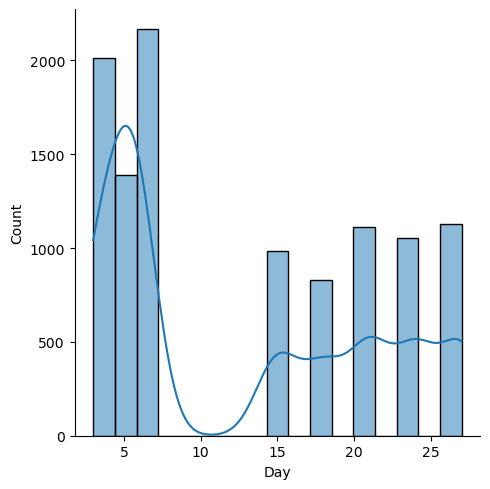

<Figure size 600x200 with 0 Axes>

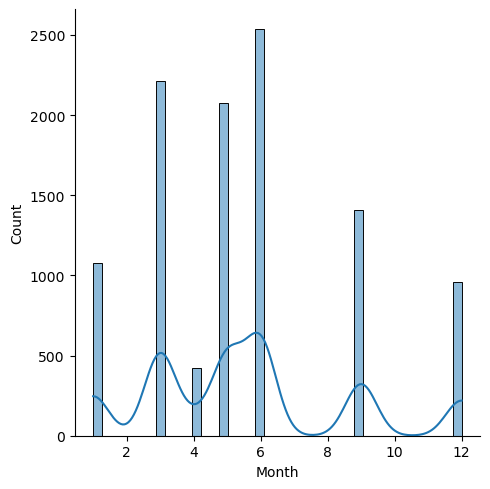

<Figure size 600x200 with 0 Axes>

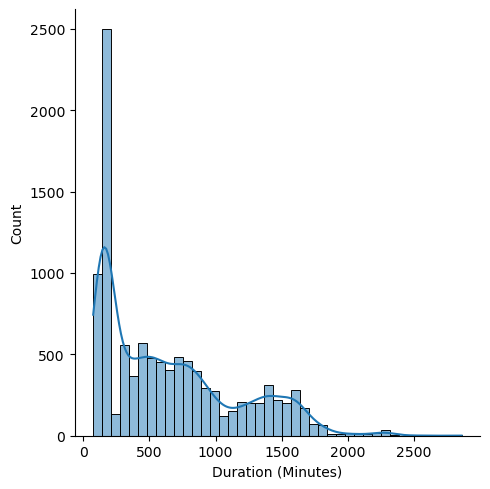

<Figure size 600x200 with 0 Axes>

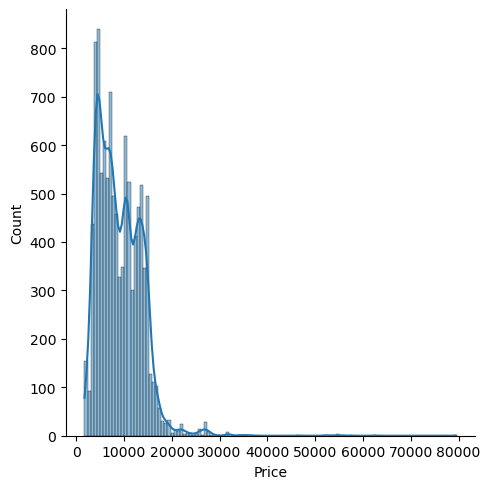

In [41]:
for num in num_col:
    plt.figure(figsize = (6,2))
    sns.displot(data = df, x = num, kde = True)
    plt.show()

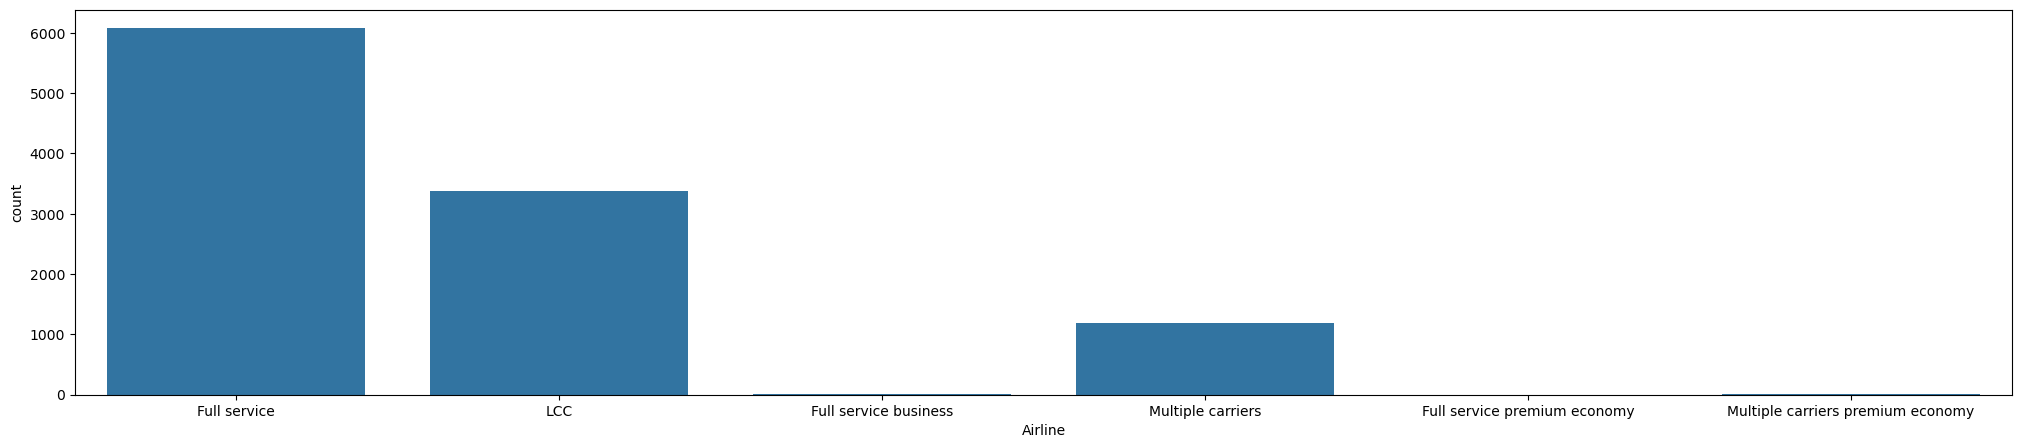

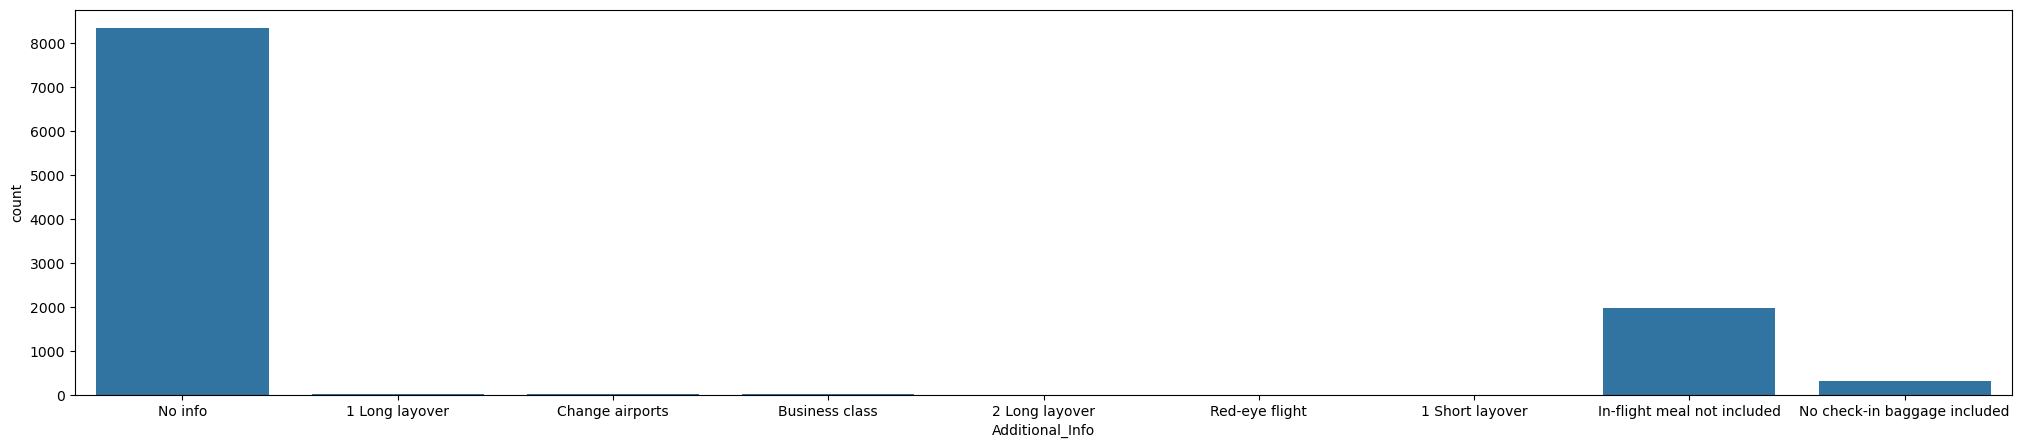

In [42]:
for cat in cat_col:
    plt.figure(figsize = (25,5))
    sns.countplot(data = df, x = cat)
    plt.show()

## Bivariate Analysis

### Between Numerical Columns

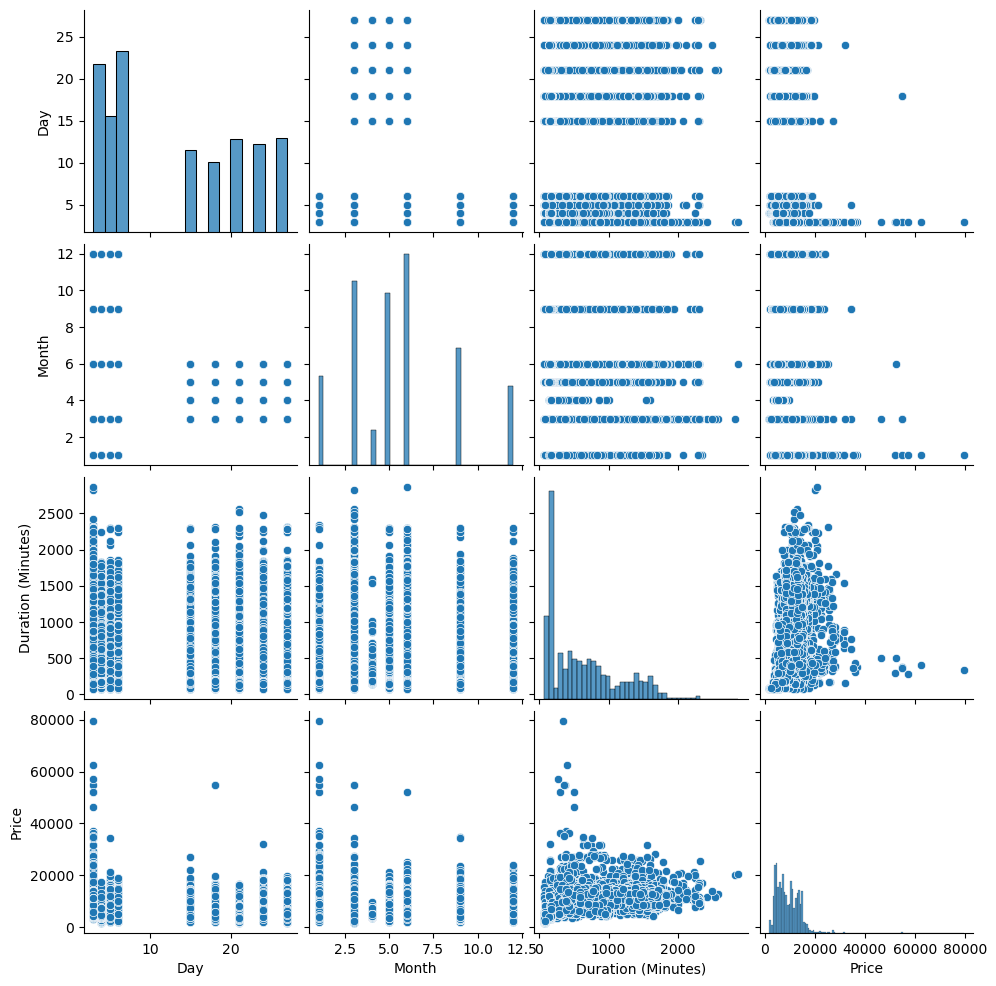

In [45]:
sns.pairplot(df)
plt.show()

### Between Categorical Columns

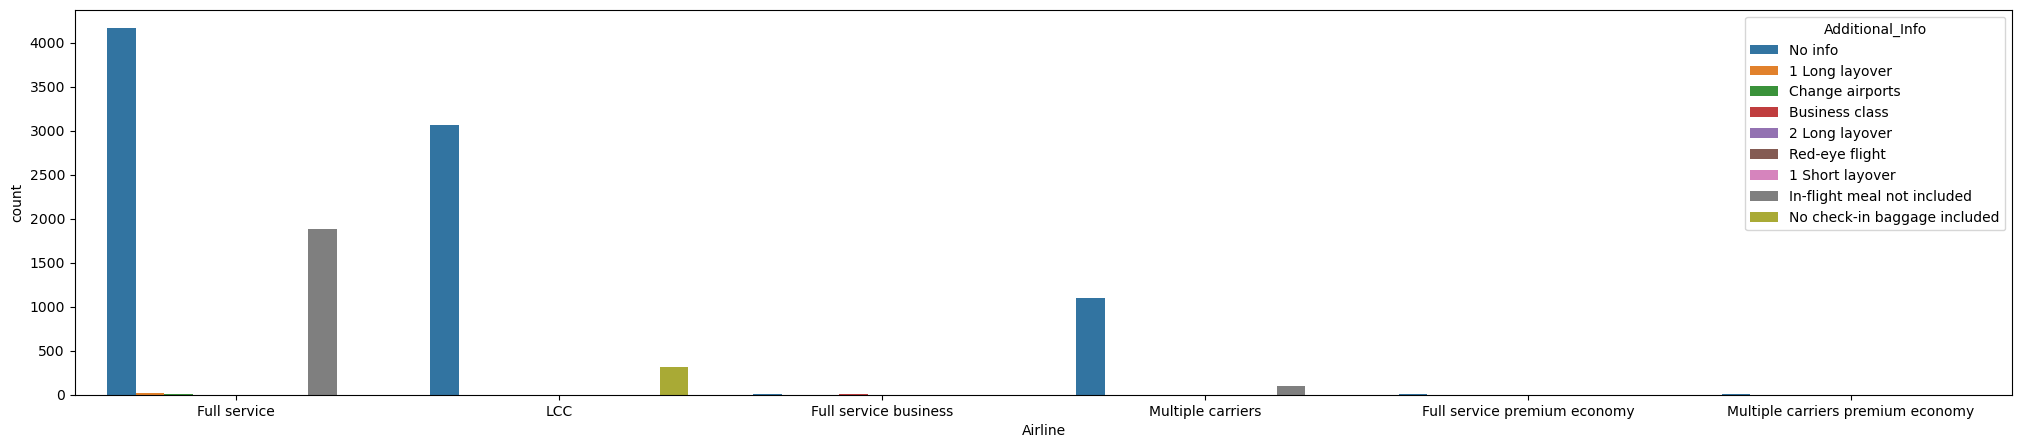

In [47]:
cat_aux = cat_col.copy()

for category1 in cat_col:
    cat_aux.pop(0);
    for category2 in cat_aux:
        if category1 != category2:
            plt.figure(figsize = (25,5))
            sns.countplot(data = df, x = category1, hue = category2, legend='auto')
            plt.show()

### Numerical and Categorical Column

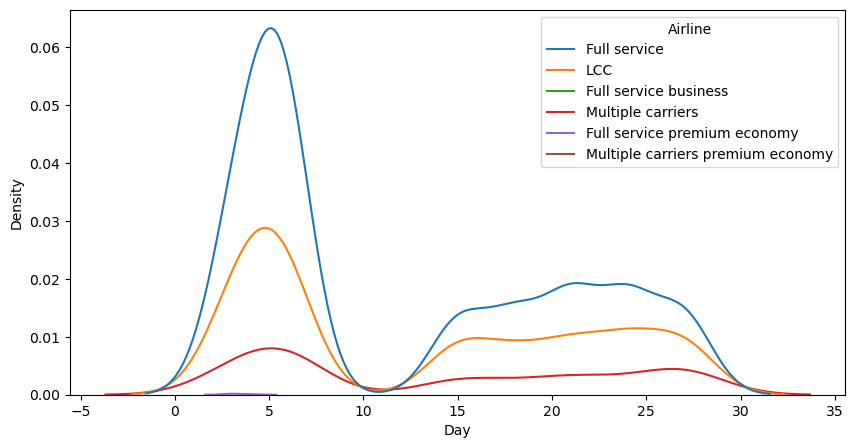

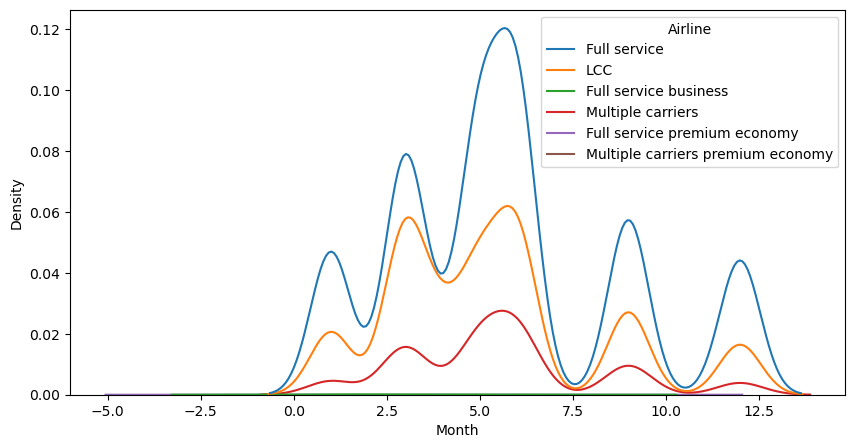

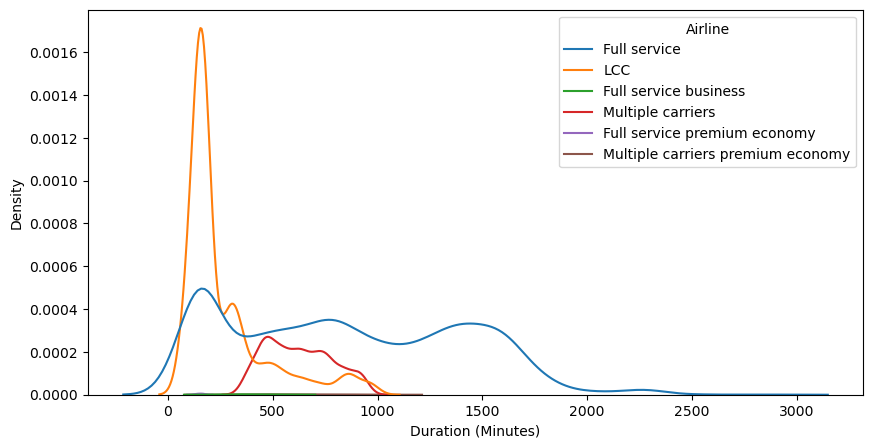

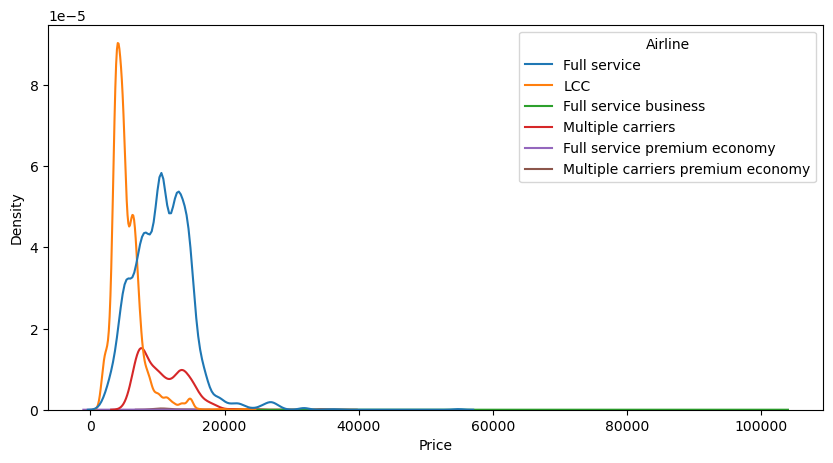

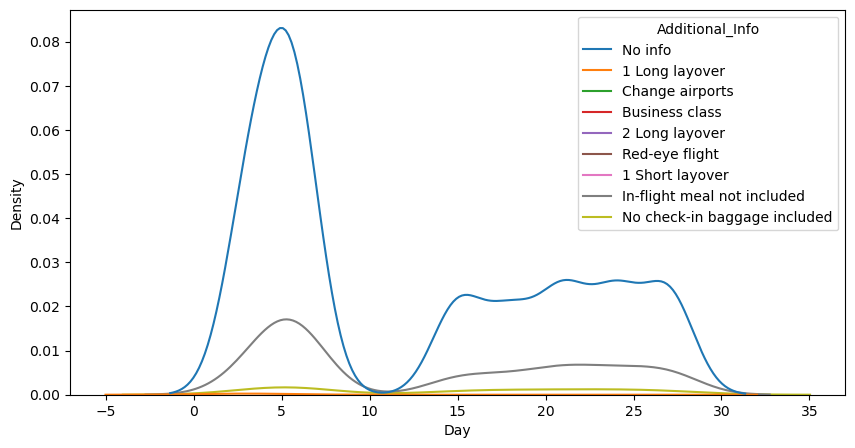

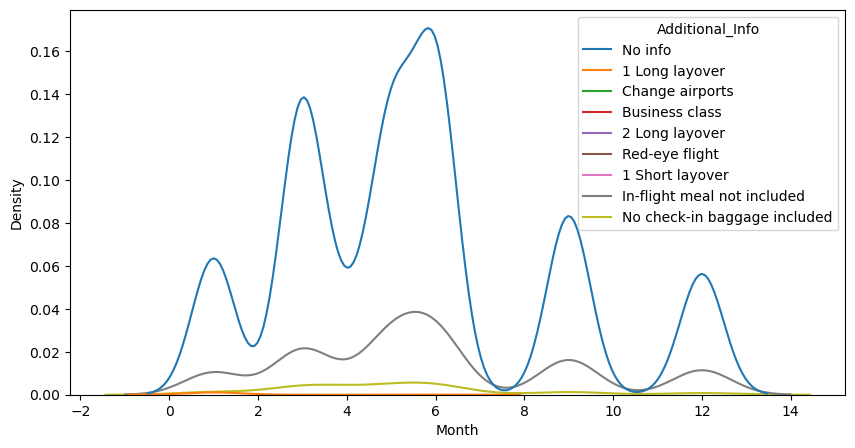

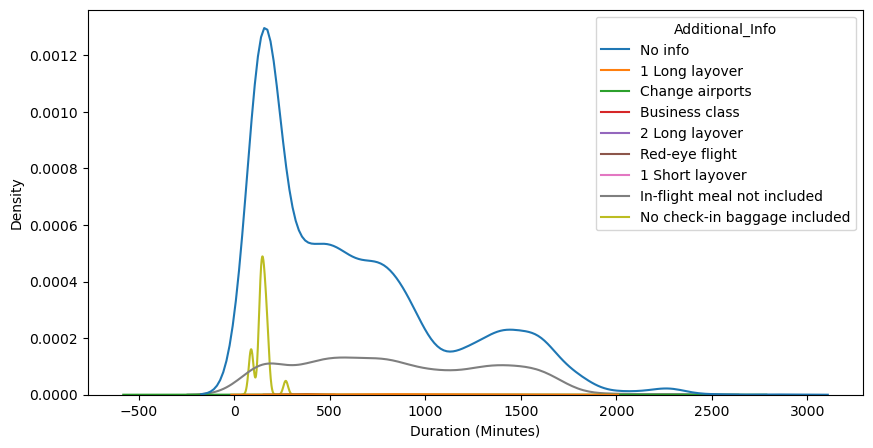

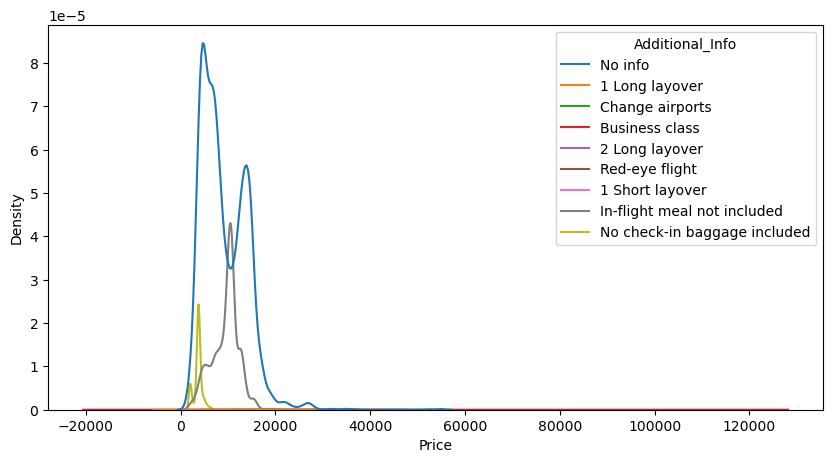

In [49]:
for cat in cat_col:
    for num in num_col:
        plt.figure(figsize = (10, 5))
        sns.kdeplot(data = df, x = num, hue = cat)
        plt.show()

## Multivariate Analysis

In [51]:
def bivariate_scatter(x, y, hue, df):
    plt.figure(figsize = (10,5))
    sns.scatterplot(x = x, y = y, data = df, hue = hue, alpha = 0.85)

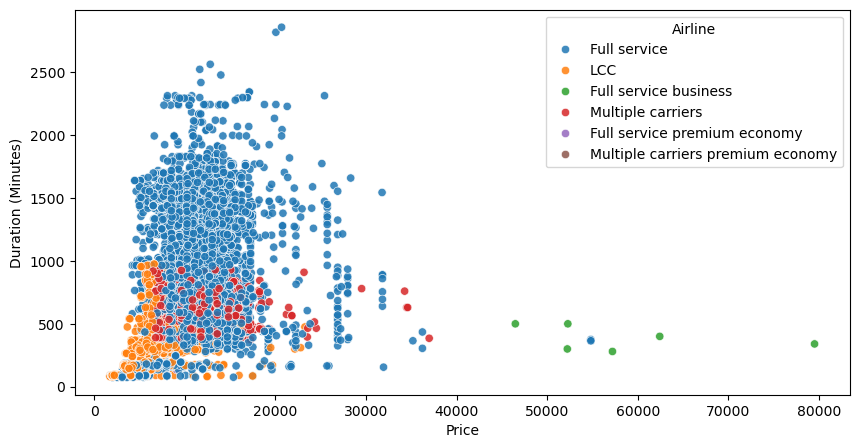

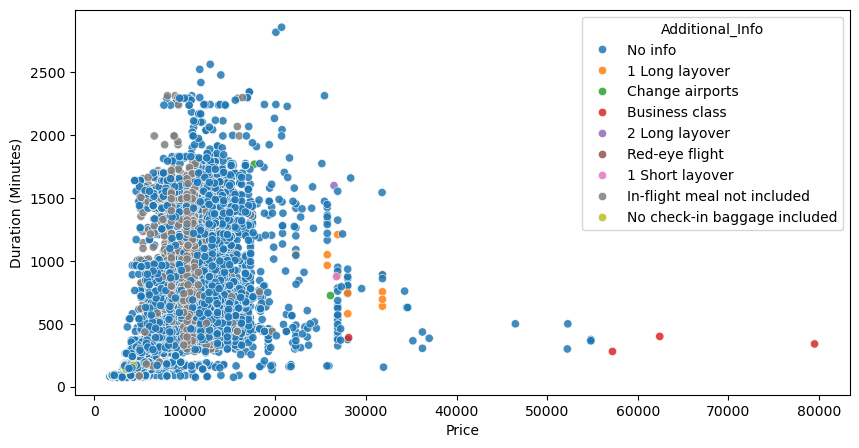

In [52]:
for cat in cat_col:
    bivariate_scatter('Price', 'Duration (Minutes)', cat, df)

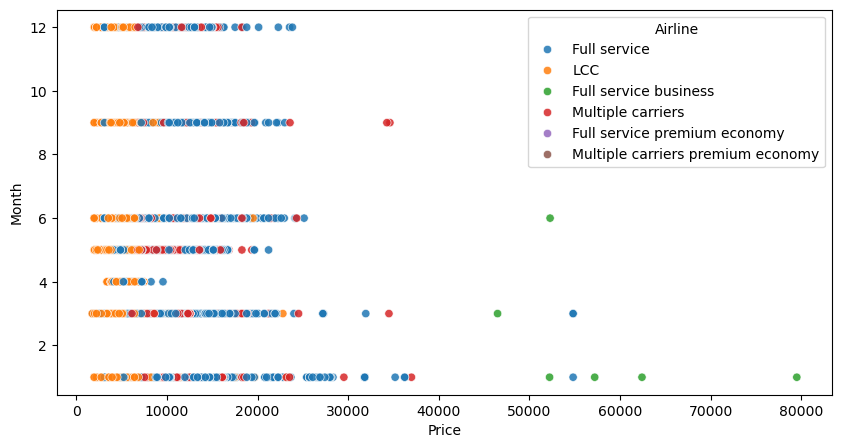

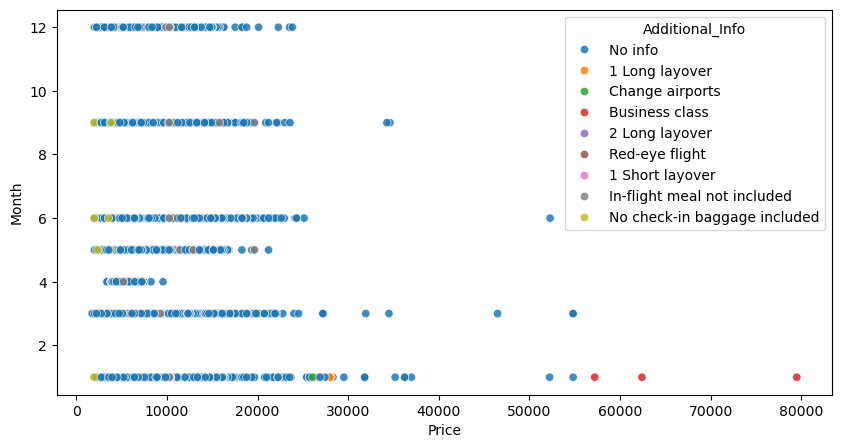

In [53]:
for cat in cat_col:
    bivariate_scatter('Price', 'Month', cat, df)

## Correlation

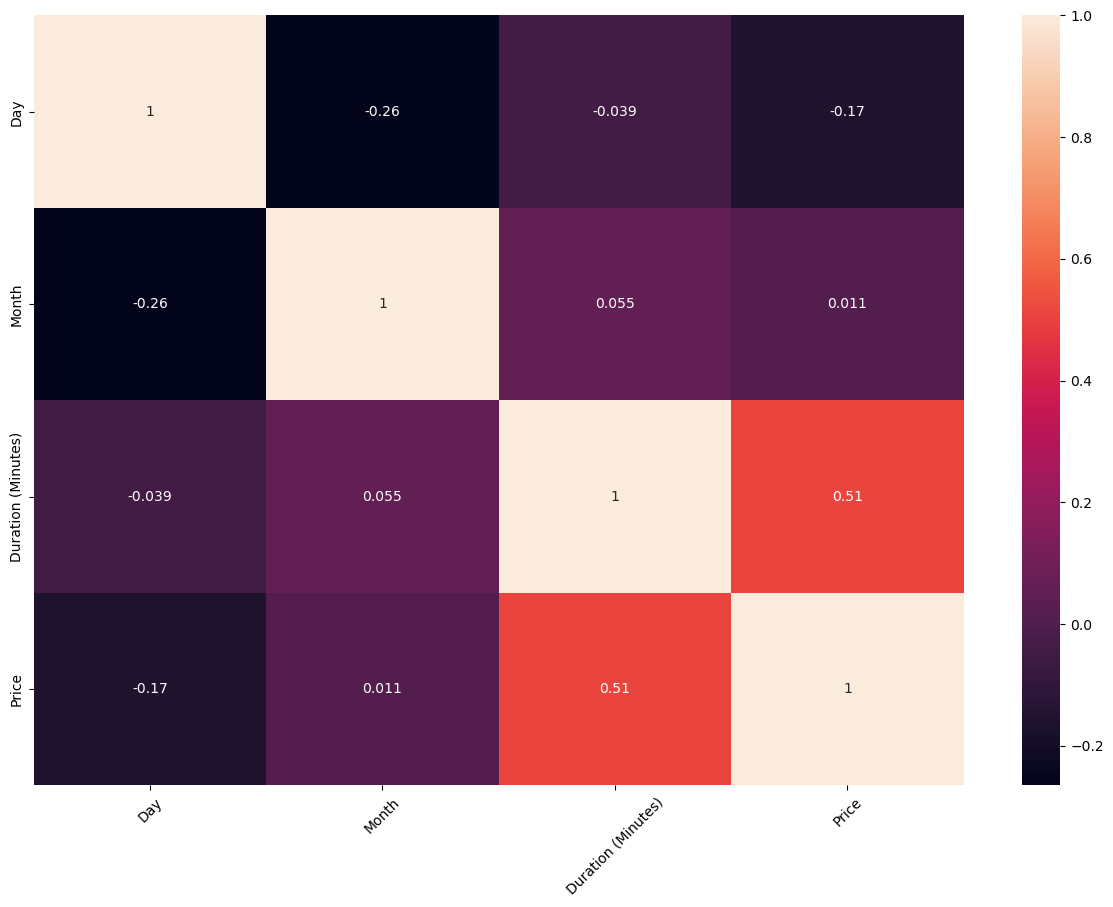

In [55]:
plt.figure(figsize = (15, 10))
sns.heatmap(df[num_col].corr(), annot = True)
plt.xticks(rotation=45)
plt.show()

## Outlier

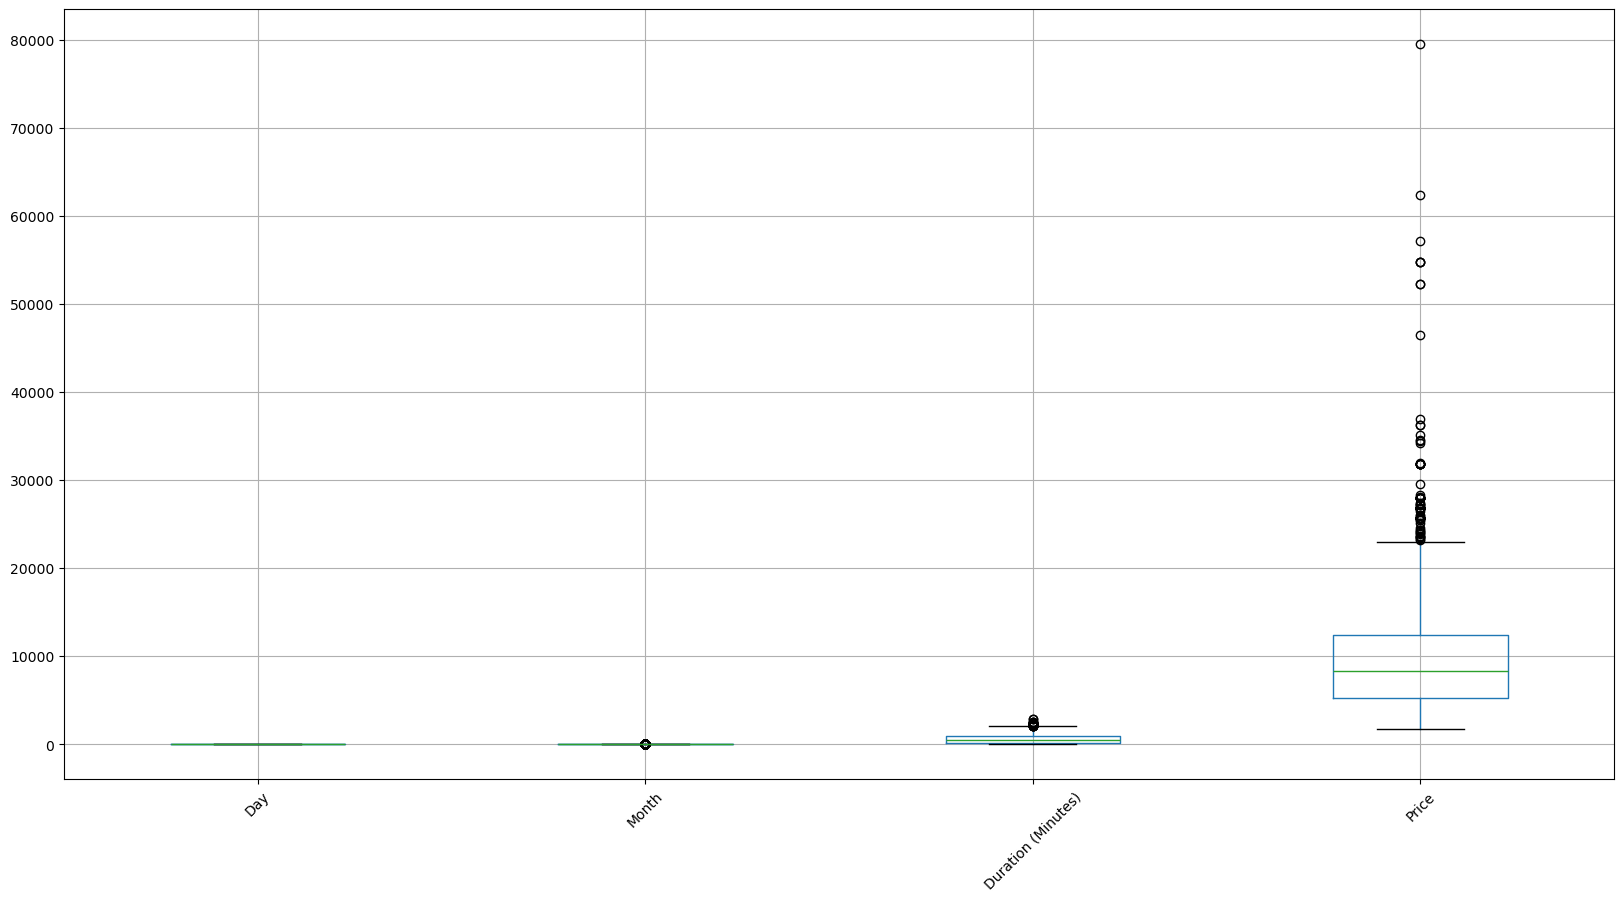

In [57]:
df.boxplot(figsize=(20, 10))
plt.xticks(rotation=45)
plt.show()

In [58]:
df.describe()

,Day,Month,Duration (Minutes),Price
count,10682.000000,10682.000000,10682.000000,10682.000000
mean,12.683112,5.534731,643.152968,9086.292735
std,8.803615,2.987626,507.848241,4610.885695
min,3.000000,1.000000,75.000000,1759.000000
25%,5.000000,3.000000,170.000000,5277.000000
50%,6.000000,5.000000,520.000000,8372.000000
75%,21.000000,6.000000,930.000000,12373.000000
max,27.000000,12.000000,2860.000000,79512.000000


# Data Preprocessing

In [60]:
df_cp = df.copy()
df_cp.head()

,Airline,Day,Month,Duration (Minutes),Additional_Info,Price
0,Full service,3,1,785,No info,26890
1,LCC,3,1,485,1 Long layover,7744
2,Full service,3,1,740,No info,27992
3,Full service,3,1,2345,No info,17135
4,Full service,3,1,1425,No info,25735


## One Hot Encoding

In [62]:
df_cp = pd.get_dummies(df_cp)
df_cp.head()

,Day,Month,Duration (Minutes),Price,Airline_Full service,Airline_Full service business,Airline_Full service premium economy,Airline_LCC,Airline_Multiple carriers,Airline_Multiple carriers premium economy,Additional_Info_1 Long layover,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight
0,3,1,785,26890,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,3,1,485,7744,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
2,3,1,740,27992,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,3,1,2345,17135,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,3,1,1425,25735,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False


## Log Transformation for Price Column

In [64]:
df_cp['Price'] = np.log1p(df_cp['Price'])

<Axes: xlabel='Price', ylabel='Density'>

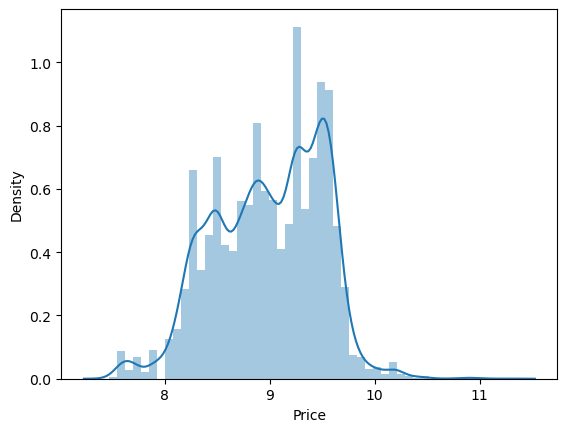

In [65]:
sns.distplot(df_cp['Price'], kde=True)

## Box Cox Transformation

In [67]:
# Check the skewness of all numerical features
skewed_feats = df_cp[num_col].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkewness in numerical features: \n")

skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skewness in numerical features: 



,Skew
Duration (Minutes),0.860937
Month,0.629467
Day,0.367182
Price,-0.254493


In [68]:
skewness = skewness[abs(skewness['Skew']) > 0.75]

print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 1 skewed numerical features to Box Cox transform


In [69]:
skewed_features = skewness.index
lam = 0.20

for feat in skewed_features:
    df_cp[feat] = boxcox1p(df_cp[feat], lam)

In [70]:
df_cp.head()

,Day,Month,Duration (Minutes),Price,Airline_Full service,Airline_Full service business,Airline_Full service premium economy,Airline_LCC,Airline_Multiple carriers,Airline_Multiple carriers premium economy,Additional_Info_1 Long layover,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight
0,3,1,13.969440,10.199547,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,3,1,12.230475,8.954803,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
2,3,1,13.747081,10.239710,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,3,1,18.606718,9.748937,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,3,1,16.369478,10.155646,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [71]:
# Check the skewness of all numerical features
skewed_feats = df_cp[num_col].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkewness in numerical features: \n")

skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skewness in numerical features: 



,Skew
Month,0.629467
Day,0.367182
Duration (Minutes),0.037870
Price,-0.254493


## Split Data

In [73]:
X = df_cp.drop(columns = 'Price')
y = df_cp['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("Dimension of X_train dataset:", X_train.shape)
print("Dimension of y_train dataset:", y_train.shape)
print("Dimension of X_test dataset:", X_test.shape)
print("Dimension of y_test dataset:", y_test.shape)

Dimension of X_train dataset: (8545, 18)
Dimension of y_train dataset: (8545,)
Dimension of X_test dataset: (2137, 18)
Dimension of y_test dataset: (2137,)


## Scaling

In [75]:
scaler = MaxAbsScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [76]:
X_train

array([[0.18518519, 1.        , 0.45914231, ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.33333333, 0.46731281, ..., 0.        , 1.        ,
        0.        ],
       [0.22222222, 0.08333333, 0.45914231, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.88888889, 0.41666667, 0.46731281, ..., 0.        , 0.        ,
        0.        ],
       [0.22222222, 0.08333333, 0.74313961, ..., 0.        , 1.        ,
        0.        ],
       [0.55555556, 0.5       , 0.74963244, ..., 0.        , 0.        ,
        0.        ]])

In [77]:
pickle.dump(scaler, open('scaling.pkl', 'wb'))

# Modelling

In [79]:
model = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(),
    'Bagging': BaggingRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor()
}

results = []

for model_name, model in model.items():
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    
    y_test_pred = model.predict(X_test)
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    results.append({
        'Model Name': model_name,
        'R2 Train': r2_train,
        'R2 Test': r2_test,
        'MAE Train': mae_train,
        'MAE Test': mae_test,
    })

results_df = pd.DataFrame(results).sort_values(by=['R2 Train', 'R2 Test', 'MAE Train', 'MAE Test'], ascending=[False, False, True, True])
results_df

,Model Name,R2 Train,R2 Test,MAE Train,MAE Test
4,Decision Tree,0.958449,0.774779,0.048519,0.161052
6,Random Forest,0.946244,0.824536,0.076649,0.147257
5,Bagging,0.941592,0.814486,0.078739,0.151337
9,XGBoost,0.902310,0.840928,0.116750,0.145470
8,Gradient Boosting,0.817916,0.809220,0.169547,0.172054
7,SVR,0.716614,0.709839,0.205475,0.205374
0,Linear Regression,0.630276,0.623599,0.240201,0.237610
2,Ridge,0.630120,0.623631,0.240350,0.237623
1,Lasso,0.000000,-0.002532,0.430939,0.429703
3,ElasticNet,0.000000,-0.002532,0.430939,0.429703


# Model Tuning

In [81]:
rf = RandomForestRegressor(random_state=42)

parameters = {
    'n_estimators': [10, 100],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(estimator=rf, param_grid=parameters, cv=3, verbose=2)

grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best Parameters found: {grid_search.best_params_}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END criterion=squared_error, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END criterion=squared_error, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END criterion=squared_error, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END criterion=squared_error, max_features=log2, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_features=log2, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_features=log2, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=squared_error, max_feature

In [82]:
rf = RandomForestRegressor(criterion='absolute_error', max_features=None, n_estimators=100, random_state=42)

model = rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

y_test_pred = rf.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f'Train R2 Score: {r2_train}')
print(f'Train Mean Absolute Error: {mae_train}\n')

print(f'Test R2 Score: {r2_test}')
print(f'Test Mean Absolute Error: {mae_test}')

Train R2 Score: 0.9414359116840935
Train Mean Absolute Error: 0.08037810944258078

Test R2 Score: 0.8238096873321316
Test Mean Absolute Error: 0.1480614956935599


In [83]:
pickle.dump(model, open('model.pkl', 'wb'))